In [28]:
from sklearn.mixture import GaussianMixture
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

In [6]:
pca_df = pd.read_csv('pca_df.csv')
df_subset = pd.read_csv('df_subset.csv')

In [7]:
my_colors_2 = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap_2 = LinearSegmentedColormap.from_list('custom_cmap_2', my_colors_2)

# Model based clustering

## Gaussian Mixture

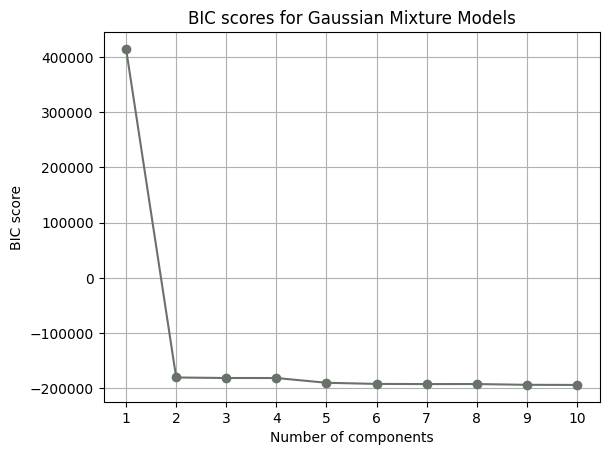

In [35]:
n_components_range = range(1, 11)
bic_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(pca_df)
    bic_scores.append(gmm.bic(pca_df))

# Plot the BIC scores against the number of components
plt.plot(n_components_range, bic_scores, marker='o', color = '#697268')
plt.xlabel('Number of components')
plt.ylabel('BIC score')
plt.title('BIC scores for Gaussian Mixture Models')
plt.xticks(n_components_range)
plt.grid(True)
plt.show()

#### ChatGPT
A negative Bayesian Information Criterion (BIC) value is not inherently meaningful in isolation. BIC is a criterion for model selection that balances goodness of fit and model complexity, penalizing models with more parameters to prevent overfitting. The BIC score itself can be negative, positive, or zero depending on the specific model and data.

The BIC formula includes a penalty term that depends on the number of parameters in the model. If the goodness of fit term (-2 * log likelihood) is smaller than the penalty term (k * log(n)), the overall BIC score can be negative.

The sign of the BIC score is not as important as its value relative to other BIC scores for different models. When comparing models, the one with the lowest BIC score is preferred, regardless of whether the score is negative or positive. This indicates the model that best balances goodness of fit and model complexity for the given data.

So, while a negative BIC score might seem unusual, it doesn't affect the interpretation of model selection. The key is to compare BIC scores across different models and choose the model with the lowest BIC score as the best-fitting model.

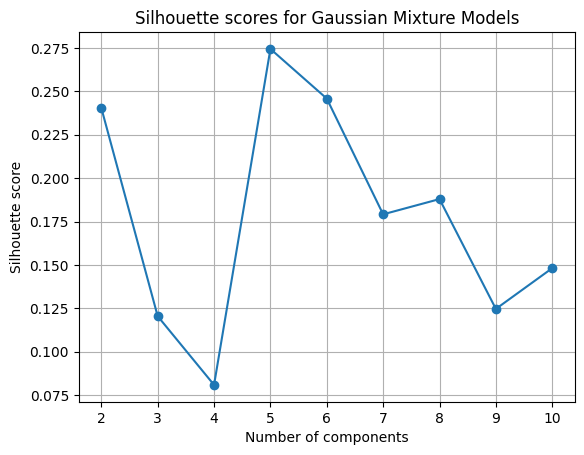

In [34]:
from sklearn.metrics import silhouette_score

n_components_range = range(2, 11)  # Start from 2 as silhouette score requires at least 2 clusters
silhouette_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(pca_df)
    labels = gmm.predict(pca_df)
    silhouette_scores.append(silhouette_score(pca_df, labels))

# Plot the silhouette scores against the number of components
plt.plot(n_components_range, silhouette_scores, marker='o', color = '#697268')
plt.xlabel('Number of components')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores for Gaussian Mixture Models')
plt.xticks(n_components_range)
plt.grid(True)
plt.show()


so, 5 clusters as is where the BIC is the lowest and starts decreasing more slowly and is where the silhouette index is the highest

In [36]:
gaussian_mix = GaussianMixture(n_components=5, random_state=42, verbose=1)
gaussian_mix.fit(pca_df)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(n_components=5, random_state=42, verbose=1)

In [37]:
with open('results_pca/model_based/gaussian_mix.pickle', 'wb') as f:
    pickle.dump(gaussian_mix, f)

In [38]:
with open('results_pca/model_based/gaussian_mix.pickle', 'rb') as f:
    gaussian_mix = pickle.load(f)

In [39]:
labels = gaussian_mix.predict(pca_df)

In [57]:
len(np.unique(labels))

5

In [40]:
probs = gaussian_mix.predict_proba(pca_df)

In [41]:
means = gaussian_mix.means_
covariances = gaussian_mix.covariances_

In [42]:
df_subset = df_subset.loc[:,:'farm']
pca_df = pca_df.loc[:,:'PC2']

In [43]:
# Assign the cluster labels to the original DataFrame
# pca_df['cluster_label'] = model_single.labels_
pca_df['cluster_label'] = labels
pca_df['asset_id'] = df_subset['asset_id']

df_subset['cluster_label'] = labels

In [44]:
df_subset.to_csv('results_pca/model_based/csv_labels_cut_raw/gaussian_mix.csv', index = False)

In [45]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df_subset = df_subset.loc[:,:'farm']

df_subset = pd.merge(df_subset, most_frequent_clusters, on='asset_id', how='left')

df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,4
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1,4
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1,4
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1,4
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1,4


In [46]:
len(most_frequent_clusters.unique())

2

In [47]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.253143,-0.763049,11,4
1,-0.374977,-1.197599,11,4
2,1.976068,-0.386187,11,4
3,-1.228114,-1.370854,11,4
4,1.454437,-1.465956,11,4


In [48]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.253143,-0.763049,4
1,12,-3.048094,0.908466,4
2,13,-2.296033,-0.692692,4
3,14,4.322358,0.855529,4
4,15,-3.222389,1.460962,4
...,...,...,...,...
66,414,-1.996917,-1.151260,4
67,415,-0.195303,-1.531435,4
68,510,-1.418674,0.145497,4
69,511,1.187020,0.759987,4


In [49]:
pca_df = pca_df.drop(columns='asset_id')

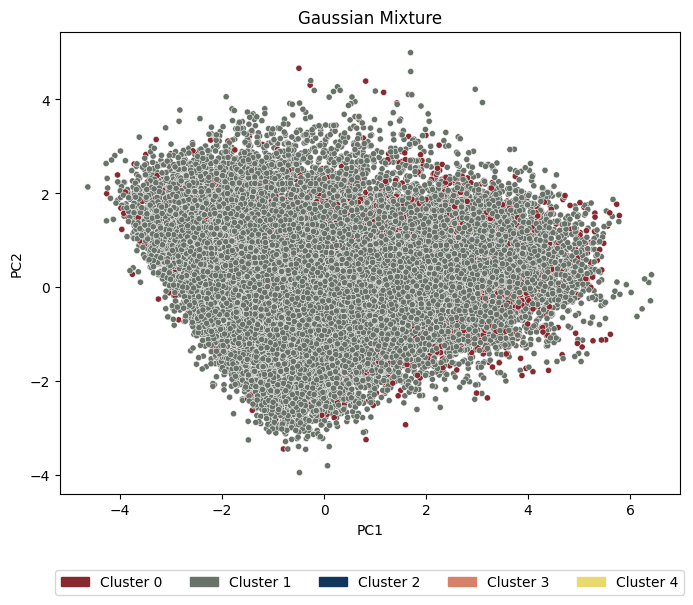

In [55]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors_2, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Gaussian Mixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors_2]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [58]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 3: [6, 7, 9, 11, 14, 17, 45, 50, 51, 53]
Cluster 4: [0, 1, 2, 3, 4, 5, 8, 10, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


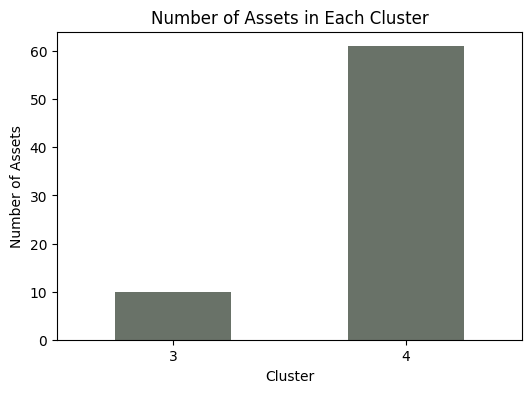

In [60]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors_2[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [61]:
df_subset.to_csv('results_pca/model_based/labels_most_common/gaussian_mix.csv', index= False)

In [62]:
df_subset = df_subset.loc[:,:'farm']
pca_df = pca_df.loc[:,:'PC2']